# Analyzing Data with Spark

AUBRIOT, Vincent
TEMPLIER, William

##  Overview

This notebook contains our analysis proposition for the LSDM project, that focuses on a dataset published by Google that contains activity and configuration information for 12.5k servers, over a long activity period (29 days).

During our study, we first focused on basic questions, in order to extract useful metrics and get used to how Spark works and what functions we can use to complete each task. For most of these analysis, we proposed two implementations, one using the RDD data structure and the second using DataFrames, in order to compare their performances when executed on a local computer.

Then, as an extension, we have tested the two different implementations  on a cloud instance. This allows us to process the analysis on the entirety of the dataset with a large number of workers (instead of working with only one thread on a small subset). The codes for each job are located on the job folder, and the results are introduced at the end of each job in this notebook.

## Job 0 - Loading the libraries and starting PySpark

We start by importing useful librairies, and launching pyspark.

In [1]:
# Libraries for Visualization
import seaborn as sns
import matplotlib.pyplot as plt
colors = sns.color_palette('viridis')

# Parameters for the visualizations
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# For easy computation over certain datasets
import numpy as np

# Pyspark utilities
import pyspark.sql.functions as F

# Execution mode:
# Cluster = -1
# Local >= 1 (i.e., number of files to load)
EXEC_MODE = 1
# ratio of data to use (1.0 = full dataset)
sample = 1.0

# TODO
from lib import *

# start spark with 1 worker thread
sc = init()
sc.setLogLevel("ERROR")

## Job 1 - What is the distribution of the machines according to their CPU capacity?

The goal is to count all occurences of each value recorded for the cpu, and from this, to output the global distribution of the CPU capacity for the entire system.


We first load the "machine events" file, as it contains information about all of the machines available in the system.
To load the file, we use a custom class which, from a given file, creates a RDD using the current spark context.
A partial output is done to confirm that we indeed have the information we need.

We also use the custom function `create_dataframe` to generate a dataframe from the data of the requested table.

In [2]:
# Get the machine_events table from the GCloud bucket and use it with spark
me = create_dataframe('machine_events', EXEC_MODE, sample)
machine_events = Table('machine_events', sc, EXEC_MODE, sample)
machine_events.pprint(take=5)

Will download at most 1 file(s) from machine_events.
Polling bucket gs://clusterdata-2011-2/machine_events
Dowloading [/part-00000-of-00001.csv.gz]
Successfully downloaded table [machine_events] (1/1).


,time,machine_id,event_type,platform_id,cpus,memory
0,0,5,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
1,0,6,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
2,0,7,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
3,0,10,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
4,0,13,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493


### RDD Version

We could confirm that the output contains the `cpus` property that interests us for each machine. We now compute the global distribution, and we visualize it as a pie chart.

In [3]:
# Count the number of occurences for each unique value found in the cpus field, and print it
cpu_dist = machine_events.select(['cpus']).countByValue()
print("Distribution of the machines according to their CPU capacity:")
for cpu_type, value in cpu_dist.items():
    print(f'\tCPU type: {cpu_type[0]}, count: {value}')

Distribution of the machines according to their CPU capacity:
	CPU type: 0.5, count: 35015
	CPU type: 0.25, count: 510
	CPU type: 1, count: 2223
	CPU type: NA, count: 32


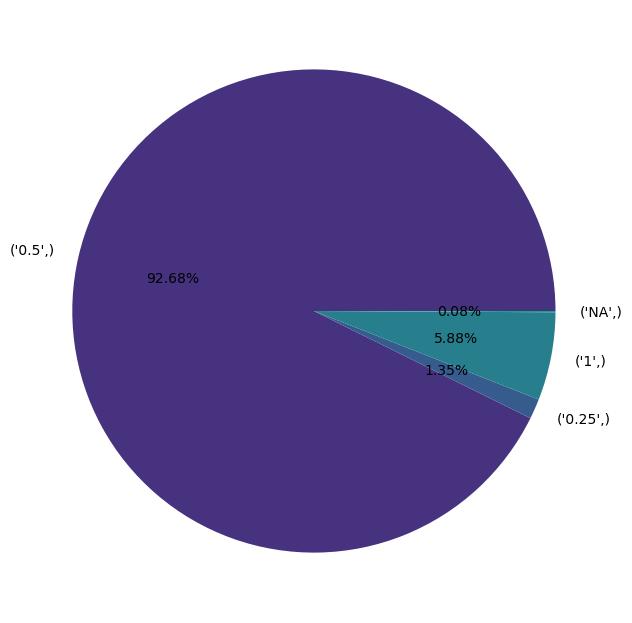

In [4]:
# Show it as a pie chart to have a clear representation of the cpus distribution across the entire set of machines
plt.pie(cpu_dist.values(), labels=cpu_dist.keys(), colors = colors, autopct='%.2f%%')
plt.show()

From the visualization shown above, we see that a large majority of the machines is using what would be called an "average" CPU (around 92 to 93% of the entire set). The remaining is mostly using a higher-end CPU (5 to 6%), and around 1% have a lower-end CPU. The data are missing for a few machines.

### Dataframe version

For the Dataframe versions, we won't display as many visualizations as in the RDD versions, because they are likely to be the samefor every job. Thus, we will mostly display the useful data for the work we are doing.

In [5]:
me.groupBy('cpus').count().show()

+----+-----+
|cpus|count|
+----+-----+
|0.25|  510|
|  NA|   32|
| 0.5|35015|
|   1| 2223|
+----+-----+



### Cluster execution

As the `machine_events` table consists of only one file, executing *Job 1* on a cluster is meaningless: the overhead of paralellizing is greater than the gain it incurs.

**Time:**
* RDD local: 0.3 s
* RDD cluster: 16.64 s
* DF local: 3.3 s
* DF cluster: 7.96 s

## Job 2 - On average, how many tasks compose a job?

Now, we focus on the jobs that were running during the analyzed period. We know that each job is composed of multiple tasks, but no information was provided about the average number of tasks in a single job.

In order to compute it, we load the task_events table, that lists for every task that was ever executed at the time various information, like the job to which the task is associated, the user that requested to execute the task, the priority, and the resources it requested to be able to process the calculations and terminate.

In [6]:
# Same as above, load a part of the table in memory and use it.
te = create_dataframe('task_events', EXEC_MODE, sample)
task_events = Table('task_events', sc, EXEC_MODE, sample)
task_events.pprint(3)

Will download at most 1 file(s) from task_events.
Polling bucket gs://clusterdata-2011-2/task_events
Dowloading [/part-00000-of-00500.csv.gz]
Successfully downloaded table [task_events] (1/500).


,time,missing_info,job_id,task_index,machine_id,event_type,user,scheduling_class,priority,cpu_request,memory_request,disk_space_request,different_machines_restriction
0,5611824441,NA,6251812952,1761,1306108,4,fJYeclskJqPWsAT6TX/r9X5OiIZpSEb2PBGliYAOMxM=,0,2,0.02499,0.07959,0.0003862,1
1,5611824625,NA,6251974185,252,38676295,4,fJYeclskJqPWsAT6TX/r9X5OiIZpSEb2PBGliYAOMxM=,0,2,0.02499,0.03339,0.0003862,1
2,5612587437,NA,6251995937,33,386450501,2,4Ubmtvv/epOnUEgegvGV9mCxxcZkV4z/Dm8RY/9SEYw=,0,0,0.06873,0.01193,0.0001154,0


### RDD version

Now that we have the table, we want to count for each job the associated number of tasks, and output useful metrics.

In [7]:

# Select all entries in the table, but only keep the job IDs. Then, count the occurences of each job id,
# and put it in a list. The list represents the number of tasks for each job id found.
jobs_list = task_events.select(['job_id'])
tasks_per_job = list(jobs_list.countByValue().values())

# Take the mean number of tasks and the standard derivation
mean = round(np.mean(tasks_per_job))
std = round(np.std(tasks_per_job))

print(f"A job can have between {np.min(tasks_per_job)} and {np.max(tasks_per_job)} tasks.")

# Compute high-end mean and low-end mean with the std derivation
low_mean = mean - std if (mean - std >= np.min(tasks_per_job)) else np.min(tasks_per_job)
high_mean = mean + std if (mean + std <= np.max(tasks_per_job)) else np.max(tasks_per_job)
print(f"In average, a job will have between {low_mean} and {high_mean} tasks, because the mean number of tasks in a job is equal to {mean} , and the standard deviation is equal to {std} ")

A job can have between 1 and 48582 tasks.
In average, a job will have between 1 and 965 tasks, because the mean number of tasks in a job is equal to 89 , and the standard deviation is equal to 876 


We finally produce a barplot showing the number of tasks for each process, as well as the mean, and the lower and higher means computed with regards to the standard derivation.

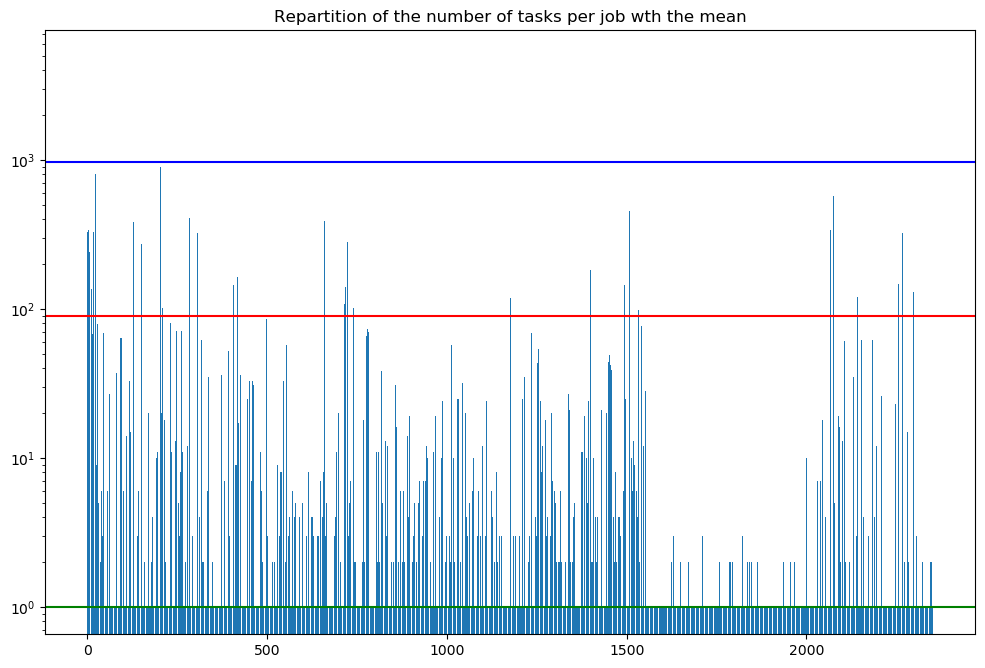

In [8]:
# Put it in a somewhat nice visualization
subset = jobs_list.sample(False, 0.1).countByValue().values()

# Bars: number of tasks for each job
plt.bar(np.arange(len(subset)), subset)

# Lines: the means (non corrected and corrected)
plt.axhline(y=low_mean, color='green', label="Lower mean")
plt.axhline(y=high_mean, color='blue', label="Higher mean")
plt.axhline(y=mean, color='red', label="Mean")

# A log scale to have a better representation (because some jobs have a really large number of tasks, 
# and a standard scale would break the visualization)
plt.yscale("log")

plt.title("Repartition of the number of tasks per job wth the mean")

plt.show()

On the graph shown above, we have represented the number of tasks for all of the studied jobs. The mean is designated by the red line, while the mean corrected with the standard derivation on lowest and highest bound is represented by the blue lines.

### Dataframe version

The process is more straigntforward when using dataframes:

- Take the job_ids, group them and count the number of occurences
- Then select the metrics over the dataframe and print them

No need to get the contents of the RDD through a list or any other method.

In [9]:
task_per_job = te.select('job_id').groupBy('job_id').count()

task_per_job.select(
        F.round(F.mean('count'),2).alias('mean'), F.round(F.stddev('count'), 2).alias('std'),
        F.min('count').alias('min'), F.max('count').alias('max')
).show()

+-----+------+---+-----+
| mean|   std|min|  max|
+-----+------+---+-----+
|88.76|876.07|  1|48582|
+-----+------+---+-----+



### Cluster execution

The `task_events` table consists of 500 files, which now makes *Job 2* interesting to run on a cluster, for performance and completeness of data:

**Data:**
* RDD:
```
mean: 215.24914732650402
std: 26646.453247846257
max: 16327120
min: 1
```

* DF:
```
+------+--------+---+--------+
|  mean|     std|min|     max|
+------+--------+---+--------+
|215.25|26646.47|  1|16327120|
+------+--------+---+--------+
```

**Time:**
* RDD cluster: 128.83 s
* DF cluster: 51.1 s

We are reassured to see the same results. We observe an even bigger discrepancy between the average number of task and the maximum: some job are composed up to 16 million tasks !! It must be quite a DAG...

We witnessed again an improved performance with the DF version.

## Job 3 - What is the distribution of the number of jobs/tasks per scheduling class?

Each job and task possess a scheduling class, represented by a number between 0 and 3, that represents the sensibility to latency of the process. The higher the number is, the more the process is sensitive to latency (i.e., the process is a critical job that generates revenue...). This classification is used to affect the resource access policy on the local machine that executes the impacted process, and processes on the higher end of the classification tend to have higer priorities.

We would like to check the distribution of tasks and jobs for each class, in order to see what kind of processes these machines were treating the most.

### RDD version

We select the job id and the scheduling class for each task. Then, we do a combination by key, in order to count the number of unique tasks and unique jobs that were attributed to each scheduling class. This implies to define our own initialization, merging and combination functions used to manage the set of jobs and tasks associated to one particular scheduling class.

In [10]:
# The init, merge and combine functions for the operation that comes right after
# The goal is to count the number of tasks per job. And to have a distinct number of jobs
# with use a set
def init(new):
    job = set()
    job.add(new)
    return [job, 1]

def merge(old, new):
    old[0].add(new)
    return [old[0], old[1] + 1]

def combine(c1, c2):
    c1[0].union(c2[0])
    return [c1[0], c1[1]+c2[1]]

Number of Jobs and Tasks for each Scheduling Class:
	scheduling class [0], #job: 434, #task: 288193
	scheduling class [1], #job: 562, #task: 66182
	scheduling class [3], #job: 50, #task: 57413
	scheduling class [2], #job: 278, #task: 116134


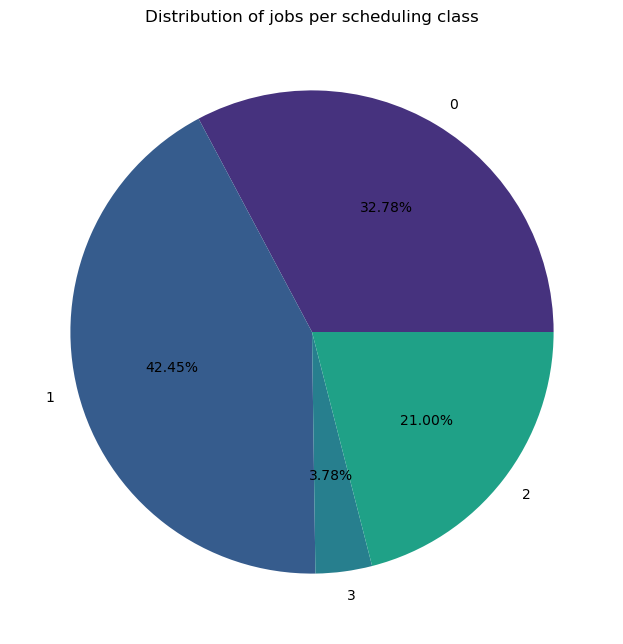

In [11]:
# Take the metrics that interests us
job_task_sched = task_events.select(['scheduling_class','job_id'])

# Combine the values by key
nb_jobs_tasks_per_sc = job_task_sched.combineByKey(init, merge, combine).mapValues(lambda x: (len(x[0]), x[1]))
print("Number of Jobs and Tasks for each Scheduling Class:")
print('\n'.join(f'\tscheduling class [{s}], #job: {j}, #task: {t}' for \
            s, (j,t) in nb_jobs_tasks_per_sc.collect()))

# Do a map to keep only the tuples (scheduling class, number of jobs)
sched_class_jobs = nb_jobs_tasks_per_sc.map(lambda x: (x[0], x[1][0]))

# Show the distribution of jobs for each scheduling class
# Done by converting the previous mapping to a Key -> Value structure that can be passed directly to the pie function
plt.pie(sched_class_jobs.collectAsMap().values(), labels=sched_class_jobs.collectAsMap().keys(), colors = colors, autopct='%.2f%%')
plt.title("Distribution of jobs per scheduling class")
plt.show()

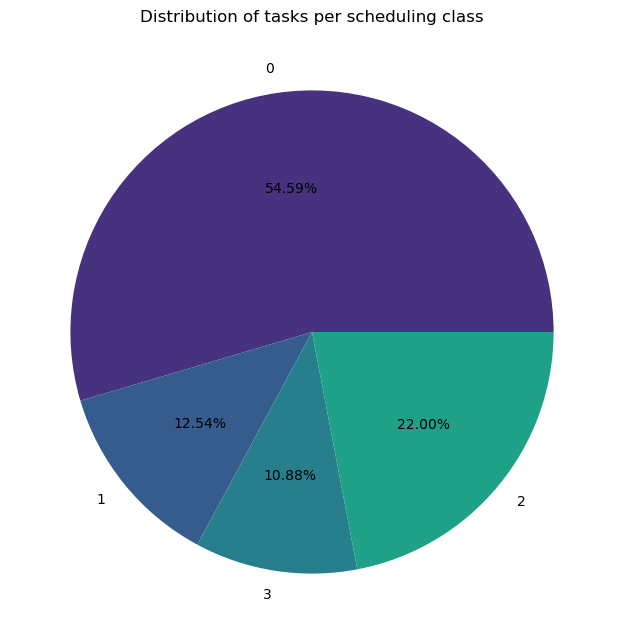

In [12]:
# Same for the tasks, by keeping the (scheduling class, number of tasks) tuples
sched_class_tasks = nb_jobs_tasks_per_sc.map(lambda x: (x[0], x[1][1]))

# And a pie chart as well
plt.pie(sched_class_tasks.collectAsMap().values(), labels=sched_class_tasks.collectAsMap().keys(), colors = colors, autopct='%.2f%%')
plt.title("Distribution of tasks per scheduling class")
plt.show()

We quickly see that most of the tasks were not really sensitive to latency, because they were assigned to the scheduling class number 0 (which holds everything that can be delayed for a while without any trouble).

Surprisingly, a great proportion of the jobs were attributed to the lowest scheduling classes, meaning that they were really not sensitive to latency.

### Dataframe version

We can see that the implementation is much more straightforward: built-in functions allow us to group on the scheduling class quite elegantly (and efficiently).

In [13]:
jts = te.select(
        te.scheduling_class, te.job_id, te.task_index
    )
jts.groupBy('scheduling_class').agg(
        F.countDistinct(jts.job_id), F.count(jts.task_index)
).orderBy(jts.scheduling_class).show()

+----------------+-------------+-----------------+
|scheduling_class|count(job_id)|count(task_index)|
+----------------+-------------+-----------------+
|               0|         1290|           288193|
|               1|         2092|            66182|
|               2|         1624|           116134|
|               3|          942|            57413|
+----------------+-------------+-----------------+



### Cluster execution

We can once again use fully the `task_events` table.

**Data:**
* RDD:
```
scheduling class [2], #job: 194497, #task: 11158598
scheduling class [0], #job: 257242, #task: 114598888
scheduling class [1], #job: 215099, #task: 18055014
scheduling class [3], #job: 5169, #task: 835788
```

* DF:
```
+----------------+-------------+-----------------+
|scheduling_class|count(job_id)|count(task_index)|
+----------------+-------------+-----------------+
|               0|       257242|        114598888|
|               1|       215099|         18055014|
|               2|       194497|         11158598|
|               3|         5169|           835788|
+----------------+-------------+-----------------+
```

**Time:**
* RDD cluster: 136.05 s
* DF cluster: 53.5 s

Even though numbers are bigger, we can see a similar distribution from the ones shown in the plots above. The elegant DF version beats the RDD version that we rewrote and rewrote. Despite the cool `combineByKey`, we cannot beat the engineers between the dataframe...

## Job 4 - Do tasks with low priority have a higher probability of being evicted?

Let's focus on the priority system. We wish to know if tasks having a low priority have a higher risk of being evicted in order to make place for the "more important" processses.

### RDD version

In [14]:
# Select the fields, and filter to keep the priority of every process at the exact moment it got evicted
task_priority_at_eviction = task_events.select(['event_type', 'priority'])\
        .filter(lambda x: x[0] == '2')\
        .map(lambda x: int(x[1]))

# Count the total number of evicted processes
total_evicted = task_priority_at_eviction.count()

# Print the distribution of each probability
number_of_evictions_foreach_priority = task_priority_at_eviction.countByValue()
print("Probability of being evicted for each priority listed:")
for k,v in sorted(number_of_evictions_foreach_priority.items()):
    print(f'\tpriority [{k}] = {round(v/total_evicted, 4)}')

Probability of being evicted for each priority listed:
	priority [0] = 0.9674
	priority [1] = 0.0121
	priority [2] = 0.0137
	priority [8] = 0.0001
	priority [9] = 0.0064
	priority [10] = 0.0001


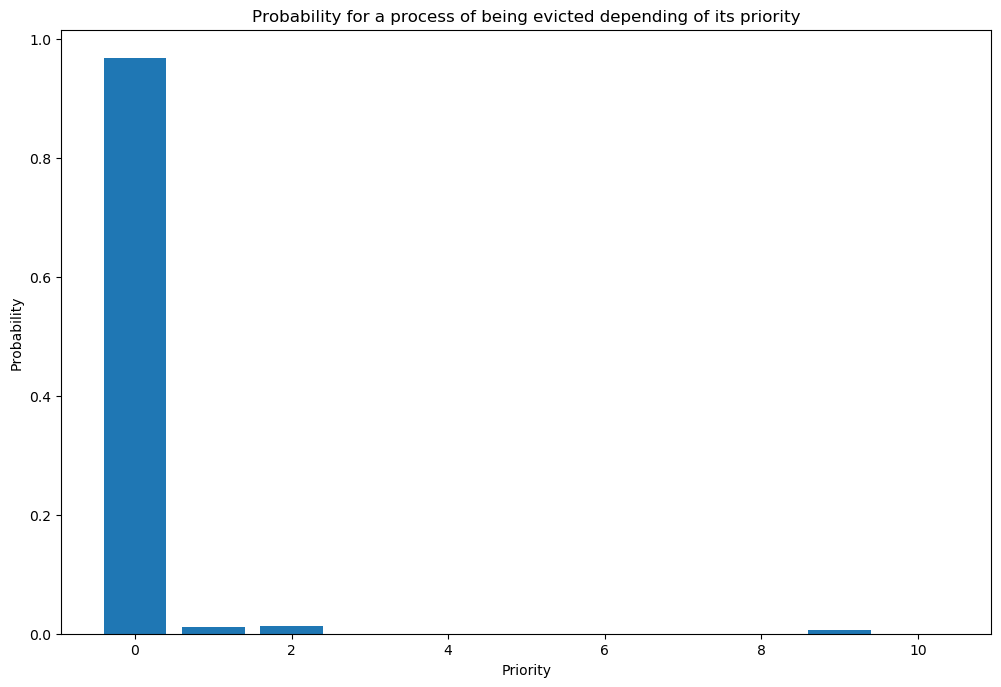

In [15]:
# Same as above, but this time in a nice graph

# Sort by priority and segregate in keys and values
sorted_number_of_evictions_foreach_priority = sorted(number_of_evictions_foreach_priority.items())
keys = [v[0] for v in sorted_number_of_evictions_foreach_priority]
values = [round(v[1]/total_evicted, 4) for v in sorted_number_of_evictions_foreach_priority]

# Print as a barchart
plt.bar(keys, values)
plt.xlabel('Priority')
plt.ylabel('Probability')
plt.title("Probability for a process of being evicted depending of its priority")
plt.show()

Indeed, lower-priority processes have a 97%-chance or higher of being evicted at any time to give way to more important processes. However, this probability drops to 1% and less as soon as the priority is equal to or above 1. 

### Dataframe version

The implementation can be written in 6 lines (or even less), and is close to what we do with a RDD.

In [16]:
# Select a priority and the associated type of event 
prievic = te.select(te.priority.cast('int'), te.event_type.cast('int'))

# Select only the ones that have a specific event type and count the number of occurences
evicted = prievic.select(prievic['*']).where((prievic.event_type == 2))
total_evited = evicted.count()

# Compute the number of process in each priority, and divide by total to get the probability
final = evicted.groupBy('priority').count()
final = final.withColumn('prob', F.round(final['count']/total_evited, 6)).sort('priority')
final.show()

+--------+-----+--------+
|priority|count|    prob|
+--------+-----+--------+
|       0| 6615|0.967388|
|       1|   83|0.012138|
|       2|   94|0.013747|
|       8|    1| 1.46E-4|
|       9|   44|0.006435|
|      10|    1| 1.46E-4|
+--------+-----+--------+



### Cluster execution

**Data:**
* RDD:
```
priority: 0 = 0.902196
priority: 1 = 0.078722
priority: 2 = 0.00809
priority: 3 = 2.6e-05
priority: 4 = 0.007429
priority: 6 = 7.2e-05
priority: 8 = 0.000511
priority: 9 = 0.002869
priority: 10 = 8.6e-05
```

* DF:
```
+--------+-------+--------+
|priority|  count|    prob|
+--------+-------+--------+
|       0|5290793|0.902196|
|       1| 461654|0.078722|
|       2|  47440| 0.00809|
|       3|    153|  2.6E-5|
|       4|  43566|0.007429|
|       6|    422|  7.2E-5|
|       8|   2997| 5.11E-4|
|       9|  16825|0.002869|
|      10|    503|  8.6E-5|
+--------+-------+--------+
```

**Time:**
* RDD cluster: 155.14 s
* DF cluster: 75.99 s

## Job 5 - In general, do tasks from the same job run on the same machine ?

Now, we wonder if the jobs are usually running on the same machine, or if the tasks composing one job are being sent to different servers to be executed.

### RDD version

In [17]:
# We select all tuples of job id and machine id in the tasks events list.
# Then, we group by key, so that one line holds the number of unique machines on which the job was executed
nb_machines_per_job = task_events.select(['job_id', 'machine_id'])\
            .sample(False, 0.1)\
            .groupByKey()\
            .mapValues(lambda x: len(set(x)))\
            .map(lambda x: (x[1],x[0]))\
            .sortByKey()
machine_njob = nb_machines_per_job.countByKey()

Text(0.5, 1.0, 'Number of machines on which was executed each job')

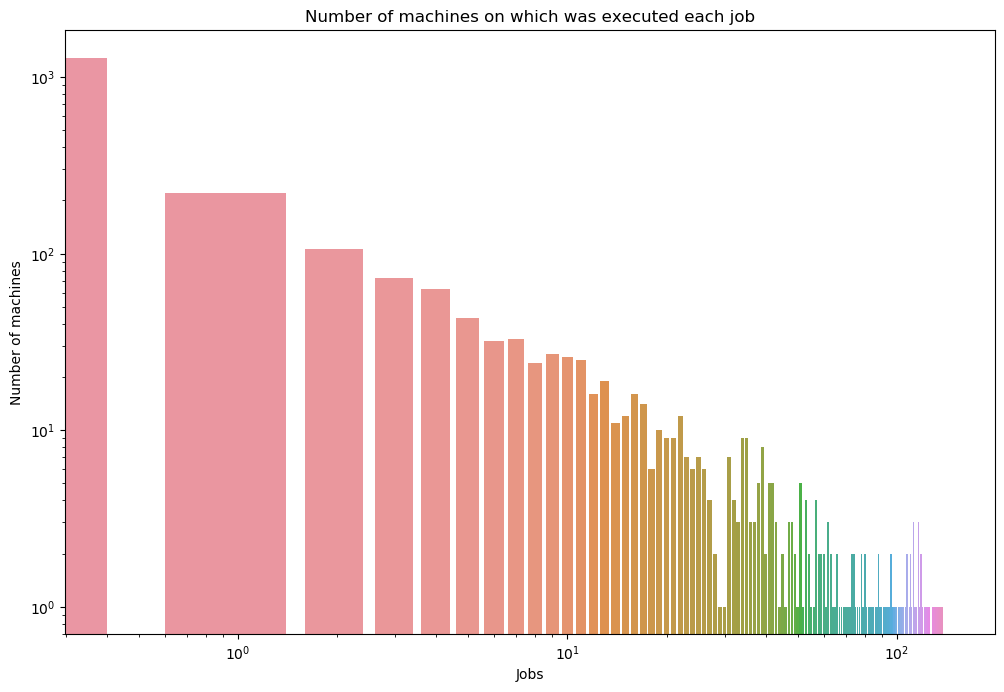

In [18]:
# We create our lists of keys and values
x=list(machine_njob.keys())
y=list(machine_njob.values())

# And then pass it to seaborn to create a barplot to have a global view
g = sns.barplot(x=x, y=y)

# There are a lot of jobs and they ran on multiple machines, so it is better to show it with a log scale
g.set_yscale("log")
g.set_xscale("log")

g.set_xlabel("Jobs")
g.set_ylabel("Number of machines")

g.set_title("Number of machines on which was executed each job")

### Dataframe version

The implementation is as short as the one with RDD.

In [19]:
m_per_f = te.select(te.job_id, te.machine_id)
final = m_per_f.groupBy('job_id').count().sort('count', ascending=False)
final.show()

+----------+-----+
|    job_id|count|
+----------+-----+
|6221861800|48582|
| 515042969|29870|
|6218406404| 9934|
|6238340468| 9177|
|6250245734| 9074|
|6225099547| 8837|
|5402488769| 8309|
|2902878580| 7767|
|6251812952| 7095|
|6251803864| 6489|
|6251726235| 6360|
|6251784940| 6330|
|6176871439| 6220|
|6176858948| 6207|
|6251414911| 6078|
|6250257820| 5002|
|6114773114| 4401|
|6250345153| 4368|
|6251277720| 4072|
|6252156189| 4051|
+----------+-----+
only showing top 20 rows



### Cluster execution

**Data:**
* RDD:
```
job [6419322512], # machines = 12273
job [515042969], # machines = 12188
job [6114773114], # machines = 11880
job [6336594489], # machines = 11828
job [6221861800], # machines = 11564
```

* DF:
```
+----------+-----+
|    job_id|count|
+----------+-----+
|6314639993|    3|
|6314795805|    3|
|6314808130|    3|
|6265699079|  206|
|6314926537|    3|
|6315025599|    3|
|6315067393|    3|
|6355175419|   21|
|6355230702|    3|
|6355265203|    3|
|6355274073|   45|
|6355309865|    3|
|6127578300|   35|
|6355359785|    3|
|6355360481|    3|
|6355374981|    3|
|6355412874|    3|
|6355433545|    3|
|6355438085|   45|
|6355485860|  186|
+----------+-----+
only showing top 20 rows
```

**Time:**
* RDD cluster: 198.46 s
* DF cluster: 48.27 s

## Job 6 - Are the tasks that request the more resources the one that consume the more resources?

To anwser this question, we need to rely on the "task_usage" logs. It holds, for each task, details about its execution, such as the start and end time, as well as the resources assigned to the task and the ones that were effectively consumed by the task.

We will process this analysis over the CPU and Memory usage, but as we don't have enough data, we will not consider the Disk IO metric (we lack any sort of request estimation, and thus can't compare the real disk usage)

We load the `task_usage` table both as a RDD and a Dataframe.

In [20]:
tu = create_dataframe('task_usage', EXEC_MODE, sample)
task_usage = Table('task_usage', sc, EXEC_MODE, sample)
task_usage.pprint(5)

Will download at most 1 file(s) from task_usage.
Polling bucket gs://clusterdata-2011-2/task_usage
Dowloading [/part-00000-of-00500.csv.gz]
Successfully downloaded table [task_usage] (1/500).


,start_time,end_time,job_id,task_index,machine_id,cpu_rate,canonical_memory_usage,assigned_memory_usage,unmapped_page_cache,total_page_cache,maximum_memory_usage,disk_i/o_time,local_disk_space_usage,maximum_cpu_rate,maximum_disk_io_time,cycles_per_instruction,memory_accesses_per_instruction,sample_portion,aggregation_type,sampled_cpu_usage
0,600000000,900000000,3418309,0,4155527081,0.001562,0.06787,0.07568,0.001156,0.001503,0.06787,2.861e-06,0.0001869,0.03967,0.0003567,2.445,0.007243,0,1,0
1,600000000,900000000,3418309,1,329150663,0.001568,0.06787,0.07556,0.0003195,0.0007,0.06787,5.722e-06,0.0001879,0.03302,0.0009289,2.1,0.005791,0,1,0
2,600000000,900000000,3418314,0,3938719206,0.0003071,0.08044,0.09521,0.0002823,0.0006704,0.08044,4.768e-06,0.0001841,0.02377,0.0007858,5.588,0.0208,0,1,0
3,600000000,900000000,3418314,1,351618647,0.0003004,0.08044,0.09521,0.0005369,0.0008698,0.08044,9.537e-06,0.0001831,0.007919,0.002285,5.198,0.02038,0,1,0
4,600000000,900000000,3418319,0,431052910,0.0004606,0.07715,0.0874,0.0006247,0.0008516,0.07715,1.907e-06,0.0002041,0.005112,0.0002146,2.937,0.009449,0,1,0


### RDD version

#### CPU usage

We start by studying the CPU usage. A good analysis would be to compare for each job and task the CPU quota requested by the process with the CPU that was actually used. Nevertheless, we realized that this is a heavy job when executed on the full dataset. As time and resources are scare - even on a cluster - we decided to go for an approximation: for each job, its requested cpu (or used) will be the average of its tasks.

To compute the average, with will used the `combineByKey` function, which need an initialization function (what to do with a new key), a combiner (put a new value wth known key) and a merger (two combiner). This will sum all values for a given **JOB** (*i.e.* requested cpu per task), and keep a counter of how many values per job. Then we divide the sum by the counter.

In [21]:
def avg_init(row):
    return (row, 1)

def avg_merge(old, new):
    return (old[0]+new,old[1]+1)

def avg_cmb(old, new):
    return (old[0]+new[0],old[1]+new[1])

#for readability, cpu/mem request and usage is multiplied by 100
sanitize = lambda x: round(float(x)*100,4)

Let's first compute our average on requested cpu

In [22]:
# Collect the cpu requested of each process by averaging on per task request,
# and discard the Non Available values.
cpu_requests = task_events.select(['job_id', 'cpu_request'])\
    .filter(lambda x: x[1] != 'NA')\
    .map(lambda x: (x[0], sanitize(x[1])))
cpu_req_avg = cpu_requests.combineByKey(avg_init, avg_merge, avg_cmb)\
    .mapValues(lambda x: round(x[0]/x[1], 3))

We then get the average CPU rates that were indeed used by each job:

In [23]:
# Same with the CPU rate
cpu_used = task_usage.select(['job_id', 'cpu_rate'])\
    .filter(lambda x: x[1] != 'NA')\
    .map(lambda x: (x[0], sanitize(x[1])))
cpu_used_avg = cpu_used.combineByKey(avg_init, avg_merge, avg_cmb)\
    .mapValues(lambda x: round(x[0]/x[1], 3))

Finally, we do a join operation to link the requests and usages in a single data structure. With this, we compute the **DELTA**, which is the diffence between requested and used cpu.

In [24]:
# for each job we match its avg cpu request and usage,
# then compute the delta REQUESTED - USAGE
cpu_consumption = cpu_req_avg.join(cpu_used_avg)
cons_delta = cpu_consumption.map(lambda x: round(x[1][0]-x[1][1], 4))

Text(0.5, 0, 'REQUESTED - USED')

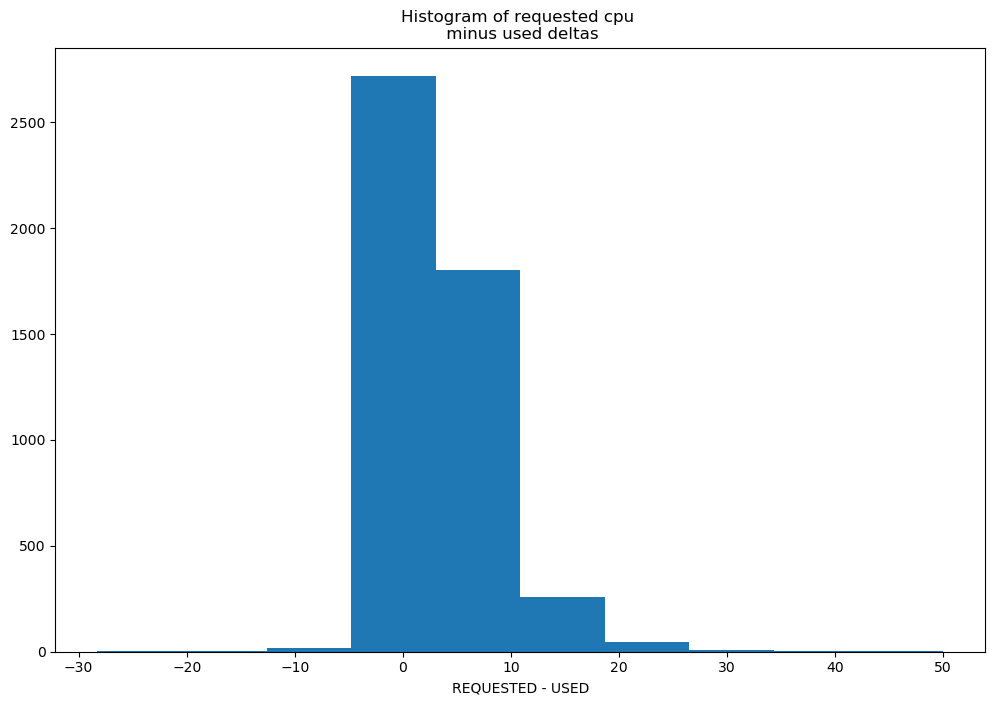

In [25]:
plt.hist(cons_delta.collect())
plt.title('Histogram of requested cpu \n minus used deltas')
plt.xlabel('REQUESTED - USED')

Above is a graph showing the CPU capacity requested by each task from each job and the CPU capacity that they have really consumed. As we can see, the most self-declared gluttonous are not ofteh the ones that are really consuming the most, as they only use a small fraction of what's available. 

Furthermore, we observe a huge fluctuation of the CPU capacity that is really consumed, where some processes are consuming nothing, and others are taking for themselves a large part of what the CPU can offer. The processes have in average almost always requested a CPU share above 0.1, but in reality they are either not taking it entirely, or in some cases they end up using more.

#### Memory usage

We now focus on memory (RAM) requests and real usage. The metrics that will be used are memory_request and canonical_memory_usage.
The process mostly remains the same as for the CPU.

In [26]:
# Collect the mem requested of each process by averaging on per task request,
# and discard the Non Available values.
mem_requests = task_events.select(['job_id', 'memory_request'])\
    .filter(lambda x: x[1] != 'NA')\
    .map(lambda x: (x[0], sanitize(x[1])))
mem_req_avg = mem_requests.combineByKey(avg_init, avg_merge, avg_cmb)\
    .mapValues(lambda x: round(x[0]/x[1], 3))

# Same with the mem rate
mem_used = task_usage.select(['job_id', 'canonical_memory_usage'])\
    .filter(lambda x: x[1] != 'NA')\
    .map(lambda x: (x[0], sanitize(x[1])))
mem_used_avg = mem_used.combineByKey(avg_init, avg_merge, avg_cmb)\
    .mapValues(lambda x: round(x[0]/x[1], 3))

# for each job we match its avg mem request and usage,
# then compute the delta REQUESTED - USAGE
mem_consumption = mem_req_avg.join(mem_used_avg)
cons_delta = mem_consumption.map(lambda x: round(x[1][0]-x[1][1], 4))

Text(0.5, 0, 'REQUESTED - USED')

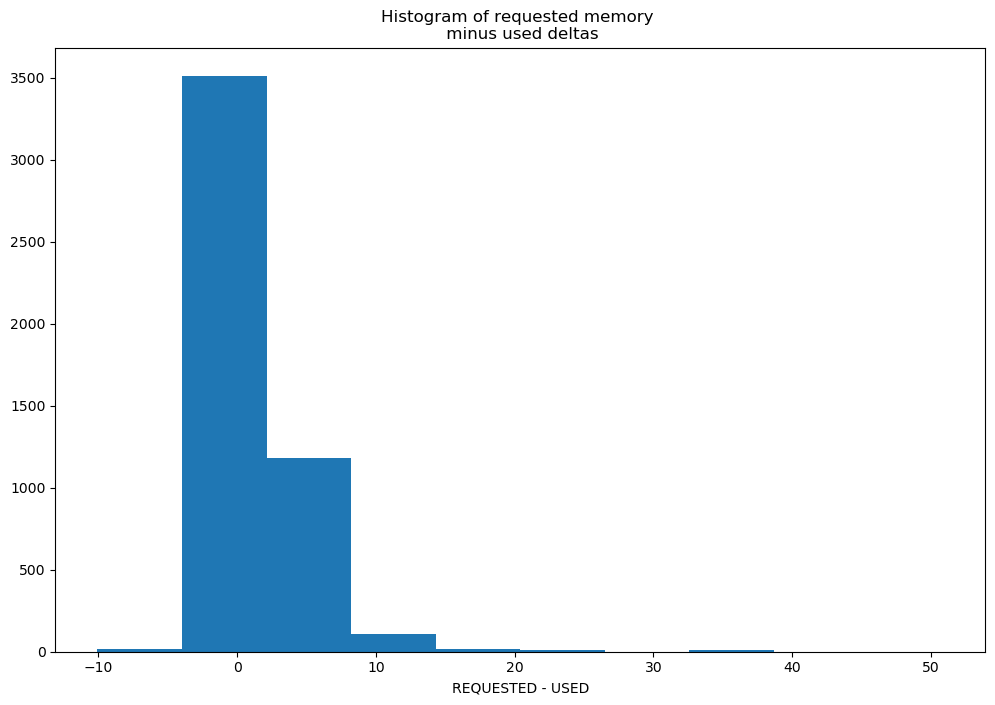

In [27]:
data = cons_delta.collect()
plt.hist(data)
plt.title('Histogram of requested memory \n minus used deltas')
plt.xlabel('REQUESTED - USED')

We observe in the above graph that the memory requests are more on par with the real consumption than what we noticed for the CPU.

### Dataframe version

For each metric, we will print the top 10 of the most gluttonous processes, and the top 10 of the most frugal ones.

#### CPU usage

In [28]:
cpu_req = te.select(
            te.job_id,
            F.round(te.cpu_request.cast('double')*100,4).alias('cpu_req')
        ).filter(te.cpu_request != 'NA')\
        .groupBy('job_id').mean('cpu_req')
        
cpu_req = cpu_req.select(cpu_req.job_id, F.round('avg(cpu_req)', 4).alias('cpu_req'))

cpu_us = tu.select(
            tu.job_id,
            F.round(tu.cpu_rate.cast('double')*100,4).alias('cpu_rate')
        ).filter(tu.cpu_rate != 'NA')\
        .groupBy('job_id').mean('cpu_rate')

cpu_us = cpu_us.select(cpu_us.job_id, F.round('avg(cpu_rate)', 4).alias('cpu_rate'))

cpu_cons = cpu_req.join(cpu_us, on='job_id')

final = cpu_cons.withColumn('delta', F.round(cpu_cons.cpu_req - cpu_cons.cpu_rate, 2))

print("Top 10 gluttonous: \n")
final.sort('delta').show(10)

Top 10 gluttonous: 

+----------+-------+--------+------+
|    job_id|cpu_req|cpu_rate| delta|
+----------+-------+--------+------+
|6243111979|   6.25| 34.5071|-28.26|
|5501666014|  18.75|   43.85| -25.1|
|6184967359|  18.75| 37.7406|-18.99|
|3873439907|12.6562| 28.0955|-15.44|
|3244870802|  3.125|  14.991|-11.87|
|6247854944| 3.0295| 14.5701|-11.54|
|6251658528|  3.125| 13.2495|-10.12|
|6119300167|12.6353| 20.3252| -7.69|
|2509801316|  20.63|   28.28| -7.65|
|6251684909|   6.25| 13.5561| -7.31|
+----------+-------+--------+------+
only showing top 10 rows



In [29]:
print("\nTop 10 frugal: \n")
final.sort('delta', ascending=False).show(10)


Top 10 frugal: 

+----------+-------+--------+-----+
|    job_id|cpu_req|cpu_rate|delta|
+----------+-------+--------+-----+
|6209468726|   50.0|  0.0044| 50.0|
|6250599310|  43.75|  0.0035|43.75|
|4872450645|  40.62|  0.0344|40.59|
|5880917954|  37.89|  0.0032|37.89|
|6210690644|   37.5|  5.4375|32.06|
|6000619150|  31.25|  1.1693|30.08|
|6000622471|  31.25|  1.2027|30.05|
|6000622646|  31.25|   1.222|30.03|
|6000618870|  38.13|  8.5826|29.55|
|6223149112|28.2835|  0.0432|28.24|
+----------+-------+--------+-----+
only showing top 10 rows



#### Memory usage

In [30]:
mem_req = te.select(
            te.job_id,
            F.round(te.memory_request.cast('double')*100,4).alias('mem_req')
        ).filter(te.memory_request != 'NA')\
        .groupBy('job_id').mean('mem_req')

mem_req = mem_req.select(mem_req.job_id, F.round('avg(mem_req)', 4).alias('mem_req'))

mem_us = tu.select(
                tu.job_id,
                F.round(tu.canonical_memory_usage.cast('double')*100,4).alias('mem_us')
        ).filter(tu.canonical_memory_usage != 'NA')\
        .groupBy('job_id').mean('mem_us')
        
mem_us = mem_us.select(mem_us.job_id, F.round('avg(mem_us)', 4).alias('mem_us'))

mem_cons = mem_req.join(mem_us, on='job_id')

final = mem_cons.withColumn('delta', F.round(mem_cons.mem_req - mem_cons.mem_us, 2))
print("Top 10 gluttonous: \n")
final.sort('delta').show(10)

Top 10 gluttonous: 

+----------+-------+-------+------+
|    job_id|mem_req| mem_us| delta|
+----------+-------+-------+------+
|4476805516|12.2126|22.2705|-10.06|
|6182353820| 7.6528|  13.79| -6.14|
|6142662891| 7.9131|13.7853| -5.87|
|6182353894| 8.3325|14.0933| -5.76|
|6214245647| 8.1443|13.6557| -5.51|
|4765556460| 8.5902|13.3182| -4.73|
|6182353639| 7.7825|12.3667| -4.58|
|6182353667|    8.5|  13.04| -4.54|
|6182353743| 8.2225|  12.72|  -4.5|
|6182354160| 8.4865|12.9567| -4.47|
+----------+-------+-------+------+
only showing top 10 rows



In [31]:
print("\nTop 10 frugal: \n")
final.sort('delta', ascending=False).show(10)


Top 10 frugal: 

+----------+-------+------+-----+
|    job_id|mem_req|mem_us|delta|
+----------+-------+------+-----+
|6088049389|  50.98|0.1223|50.86|
|6088049393|  38.28|0.1095|38.17|
|5512715900|  38.18|0.0658|38.11|
|5519874411|  38.18|0.0651|38.11|
|5515749336|  38.18|0.0739|38.11|
|5519849948|  38.18|0.0659|38.11|
|5506772520|  38.18| 0.078| 38.1|
|5519400983|  38.18|0.1001|38.08|
|4872450645|  35.01|0.0473|34.96|
|5565296141|  25.44| 0.045| 25.4|
+----------+-------+------+-----+
only showing top 10 rows



### Cluster execution

**Data:**
* RDD:

![Job 6 - RDD - CPU](results/job_6_rdd/job6_cpu_rdd_result.png)

![Job 6 - RDD - MEM](results/job_6_rdd/job6_mem_rdd_result.png)


* DF:
```
### CPU CONS### 
Top 10 gluttonous: 
+----------+-------+--------+------+
|    job_id|cpu_req|cpu_rate| delta|
+----------+-------+--------+------+
|6464224372|  3.998| 30.1044|-26.11|
|6307250860| 0.6248|   24.88|-24.26|
|6184967359|  18.75|  39.858|-21.11|
|6475531168| 0.6248|   18.16|-17.54|
|6359793838|   12.5|   29.09|-16.59|
|6402421886|  2.249| 18.2194|-15.97|
|6119828740|   0.75| 16.5595|-15.81|
|5501666014|  18.75| 34.4222|-15.67|
|6403937572|  2.689| 17.9167|-15.23|
|6382260163|   12.5| 26.4953| -14.0|
+----------+-------+--------+------+
only showing top 10 rows

Top 10 frugal: 
+----------+-------+--------+-----+
|    job_id|cpu_req|cpu_rate|delta|
+----------+-------+--------+-----+
|6268532629|   50.0|  0.0184|49.98|
|6268734026|   50.0|  0.0635|49.94|
|6346372137|  43.75|  0.0033|43.75|
|6328935123|  43.75|     0.0|43.75|
|6320270353|  43.75|  0.0031|43.75|
|6333150608|  43.75|  0.0031|43.75|
|6369448531|  43.75|  0.0035|43.75|
|6435157515|  43.75|  0.0037|43.75|
|6343801482|  43.75|  0.0036|43.75|
|6288798094|  43.75|  0.0045|43.75|
+----------+-------+--------+-----+
only showing top 10 rows

### MEM CONS ###
Top 10 gluttonous: 
+----------+-------+-------+------+
|    job_id|mem_req| mem_us| delta|
+----------+-------+-------+------+
|6223149112|  1.218|11.2599|-10.04|
|6291650278| 0.7767|  8.423| -7.65|
|6231386690|   2.78|  9.193| -6.41|
|6119828740| 0.5905|   6.99|  -6.4|
|1843579567| 0.6058| 6.3405| -5.73|
|6431770331|  3.107|  8.215| -5.11|
|6292629211| 0.7767|   5.86| -5.08|
|4476805516|17.7259|22.0106| -4.28|
|6433039963|  3.107| 7.2228| -4.12|
|6427863919|  3.107| 7.1758| -4.07|
+----------+-------+-------+------+
only showing top 10 rows

Top 10 frugal: 
+----------+-------+------+-----+
|    job_id|mem_req|mem_us|delta|
+----------+-------+------+-----+
|6308938396|  63.67|0.0955|63.57|
|6308910100|  63.67|0.4474|63.22|
|6308952765|  63.67|0.6938|62.98|
|6306258903|  63.67|0.7682| 62.9|
|6088049389|  50.98|0.1062|50.87|
|6468807724|  50.88|0.2937|50.59|
|6429554982|  47.75|0.0466| 47.7|
|6465867626|  47.75|0.0631|47.69|
|6430086351|  47.75|0.0961|47.65|
|6332768629|  46.63|0.1572|46.47|
+----------+-------+------+-----+
only showing top 10 rows
```

![Job 6 - DF - CPU](results/job_6_df/job6.1.cpu_df_result.png)

![Job 6 - DF - MEM](results/job_6_df/job6.1.mem_df_result.png)

**Time:**
* RDD cluster: 1.1361503601074219 s
* DF cluster: 1957.35 s

## Job 7 - Can we observe correlations between peaks of high resource consumption on some machines and task eviction events?

The objective of this analysis is to verify if consuming too much resources could lead a task to be evicted in favour of another one that is less glutoneous. We will collect the maximum CPU rate recorded for each job that went through the eviction step at least once, and try to see if there is a pattern behind these evictions.

### RDD version

In [32]:
# Select the maximum CPU rate consumed by each job
max_cpu_task = task_usage.select(['job_id', 'maximum_cpu_rate'])\
                .mapValues(lambda x: round(float(x)*100))\
                .reduceByKey(max)\
                .filter(lambda x: x[1] < 100)

In [33]:
# Select the jobs that were evicted
filtered_task_events = task_events.select(['job_id', 'event_type'])\
    .filter(lambda x: x[1] == '2').distinct()

# Join both RDD to have the maximum CPU rate for each evicted job
max_cpu_evt = filtered_task_events.join(max_cpu_task).map(lambda x: (int(x[1][1]), int(1))).reduceByKey(lambda a, b: a+b)

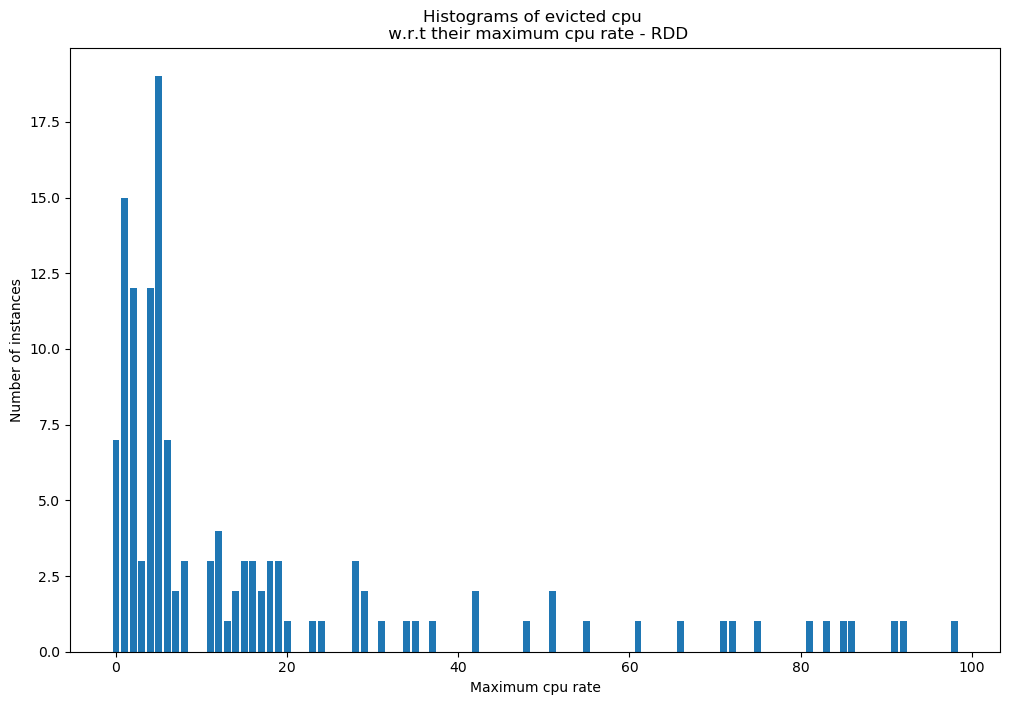

In [34]:
data = max_cpu_evt.collectAsMap()
plt.bar(data.keys(), data.values())
plt.title('Histograms of evicted cpu \n w.r.t their maximum cpu rate - RDD')
plt.xlabel('Maximum cpu rate')
plt.ylabel('Number of instances')
plt.show()

### Dataframe version

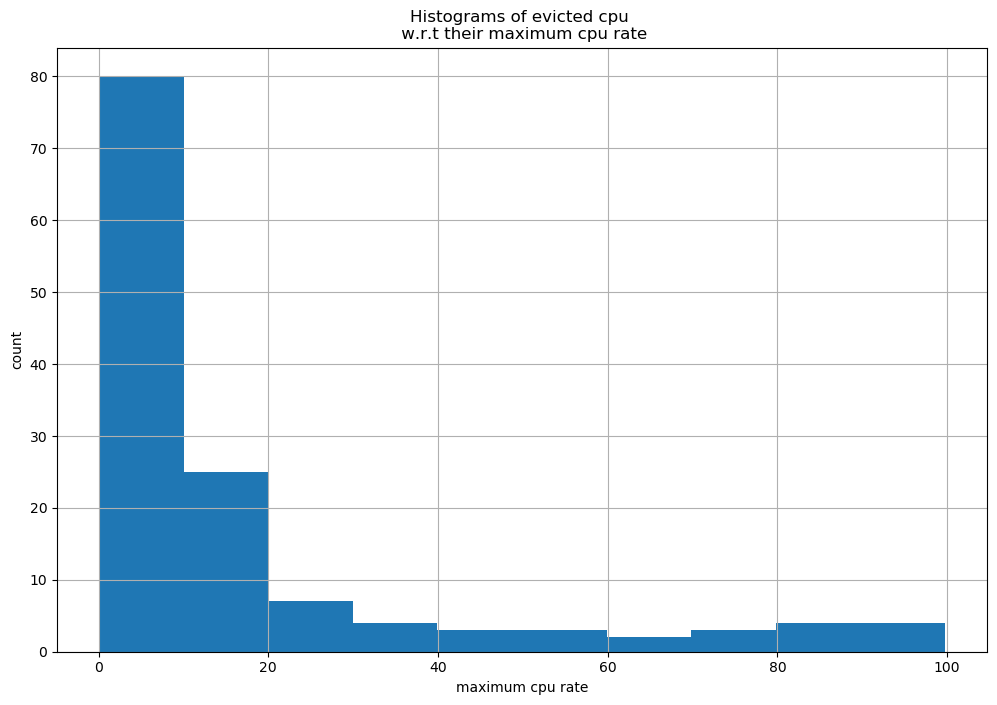

In [35]:
# Select the maximum CPU rate for each job and task, and keep only the highest one for each job
max_cpu = tu.select(
            tu.job_id,
            F.round(tu.maximum_cpu_rate.cast('double')*100 ,2).alias('mcrate')
        ).groupBy('job_id').max('mcrate')

# Filter to keep only "realistic" values (where the CPU is sollicitated at 99% at most)
max_cpu = max_cpu.select(max_cpu.job_id, F.round('max(mcrate)',2).alias('mcrate'))
max_cpu = max_cpu.filter(max_cpu.mcrate < 100)

# Select jobs that got evicted at some point
filtered_te = te.filter(te.event_type == '2').select(te.job_id).distinct()

# Join both tables and parse it as a Pandas DataFrame, that is then used to create an histogram
max_cpu_evt = filtered_te.join(max_cpu, on='job_id')

final = max_cpu_evt.toPandas()

final.hist()
plt.title('Histograms of evicted cpu \n w.r.t their maximum cpu rate')
plt.xlabel('maximum cpu rate')
plt.ylabel('count')
plt.show()

### Cluster execution

**Data:**
* DF:
  
![Job 7 - DF](results/job_7_df/job7_df_result.png)

**Time:**
* RDD cluster: 441.84 s
* DF cluster: 328.03 s

## Job 8 - Does the number of constraints of a task (including different-machine constraint) have an impact on the amount of time it spends in the PENDING state ?

### Dataframe version

From the documentation of the data provided by Google, we know that several constraints can be put on one or multiple tasks to request specific characteristics (like having a task being executed on a different computer than the others, or requesting a particular resource...).

However, we wonder if putting too many of those constraints can lead to a task spending more time on a pending state than a task with no constraints. The code provided on the next lines tries to anwser this question. Here, the Dataframe version comes first as it was the first design suggested for its implementation.

In [36]:
# Take constraints
tc = create_dataframe('task_constraints', EXEC_MODE, sample)
# Load the task_constraints table
task_constraints = Table('task_constraints', sc, EXEC_MODE, sample)

Will download at most 1 file(s) from task_constraints.
Polling bucket gs://clusterdata-2011-2/task_constraints
Dowloading [/part-00000-of-00500.csv.gz]
Successfully downloaded table [task_constraints] (1/500).


In [37]:
# Select the first timestamp at which all processes enter in PENDING state
# Only the first wait period in this state interests us
submit_status = te.select(te.job_id,te.task_index,te.event_type,te.time)\
    .filter(te.event_type == '0').drop(te.event_type)\
    .withColumnRenamed('time', 'time_start_pending')

inpending = submit_status.groupBy(['job_id', 'task_index']).agg(F.min('time_start_pending'))
inpending = inpending.withColumnRenamed('min(time_start_pending)','time_start_pending')


In [38]:
# Select the first timestamp at which all processes exit the PENDING state
outpending_status = te.select(te.job_id,te.task_index,te.event_type,te.time)\
    .filter(te.event_type.isin(['1', '3', '5', '6'])).drop(te.event_type)\
    .withColumnRenamed('time', 'time_end_pending')

outpending = outpending_status.groupBy(['job_id', 'task_index']).agg(F.min('time_end_pending'))
outpending = outpending.withColumnRenamed('min(time_end_pending)','time_end_pending')


In [39]:
# Join both sanitized dataframes together on job id and task id
fullpending = inpending.join(outpending, ['job_id', 'task_index'])

# Compute the delta for each occurence (time spent in pending state computed from both time_start_pending and time_end_pending)
fullpending_with_delta = fullpending.withColumn('delta_time', F.col('time_end_pending') - F.col('time_start_pending'))
fullpending_with_delta = fullpending_with_delta.select('job_id', 'delta_time')

# Quick output of non-null deltas to show how it looks like with interesting data
print("Showing a subset of job that have waited in PENDING state:")
fullpending_with_delta.filter(F.col('delta_time') > 0).show(10)

Showing a subset of job that have waited in PENDING state:
+----------+---------------+
|    job_id|     delta_time|
+----------+---------------+
| 515042969|1.0046362592E10|
|5495698530|      2058110.0|
|5495698530|      2058165.0|
|5664371117|  2.450274015E9|
|5664371117|  4.475973764E9|
|5664371117|  5.660587855E9|
|6218406404|  1.736168175E9|
|6218406404|  1.758708802E9|
|6218406404|  1.805049496E9|
|6218406404|  1.820799199E9|
+----------+---------------+
only showing top 10 rows



In [40]:
# Compute the mean delta time for each job
fullpending_with_delta = fullpending_with_delta.groupBy('job_id').mean('delta_time')
print("Average delta time for every job computed. Showing subset:")
fullpending_with_delta.show(5)

Average delta time for every job computed. Showing subset:
+----------+---------------+
|    job_id|avg(delta_time)|
+----------+---------------+
|5007846463|            0.0|
|5556388735|            0.0|
|5943138316|            0.0|
|6127575571|            0.0|
|6137696559|            0.0|
+----------+---------------+
only showing top 5 rows



In [41]:
# compute the mean number of constraints for each job
cons_jt = tc.select(tc.job_id, tc.task_index)
cons_jt = cons_jt.groupBy(cons_jt.job_id, cons_jt.task_index).count()
cons_jt = cons_jt.drop('task_index').groupBy('job_id').mean('count')
cons_jt = cons_jt.filter(cons_jt['avg(count)'] < 50)

# Join the number of constraints with the delta time dataframe
full_df = fullpending_with_delta.join(cons_jt, on='job_id')
full_df = full_df.sort('avg(count)', ascending=False)

print("Subset of the full joined data:")
full_df.show(5)

Subset of the full joined data:
+----------+---------------+------------------+
|    job_id|avg(delta_time)|        avg(count)|
+----------+---------------+------------------+
| 515042954|            0.0|25.153846153846153|
|2308130196|            0.0|              10.0|
|3990224152|            0.0|               8.0|
|6239317302|            0.0|               8.0|
|5425205893|            0.0|               8.0|
+----------+---------------+------------------+
only showing top 5 rows



Text(0.5, 1.0, 'Time spent on PENDING state\n depending on the number of constraints')

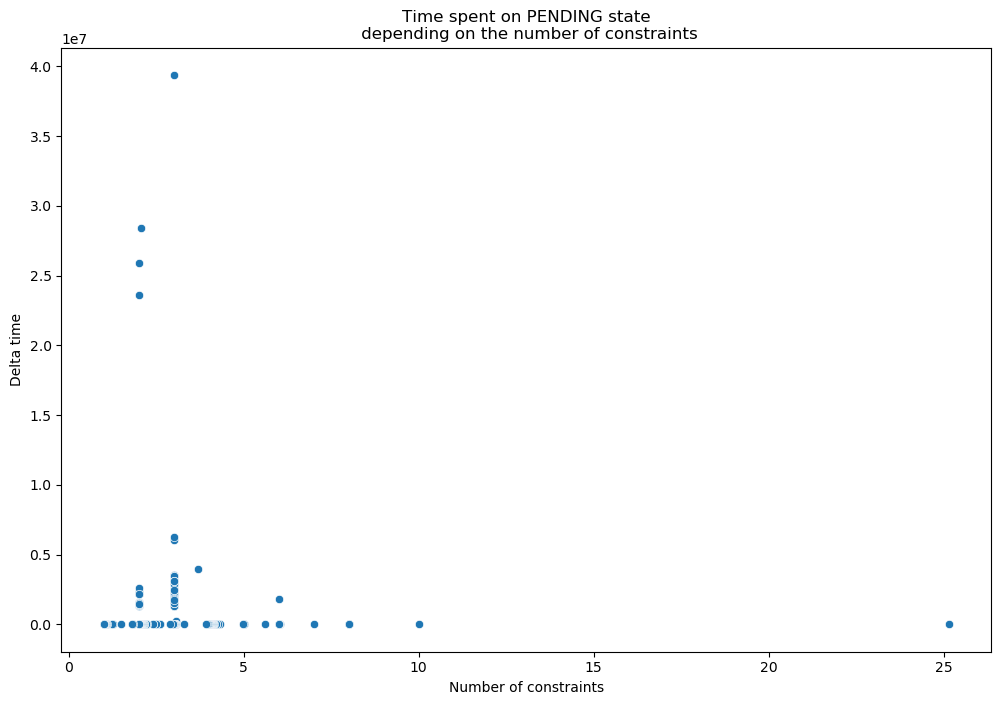

In [42]:
# And finally, display the graph
data = full_df.select('avg(delta_time)', 'avg(count)').toPandas()

g = sns.scatterplot(data=data, x='avg(count)', y="avg(delta_time)")

g.set_xlabel("Number of constraints")
g.set_ylabel("Delta time")

g.set_title("Time spent on PENDING state\n depending on the number of constraints")

From the graph shown above, we notice that despite having multiple constraints, a lot of tasks are not spending that much time in pending state (as their associated delta time is close to 0). This means that the number of these constraints does not influes directly on the time spent on pending.

Furthermore, we notice that some tasks that have no constraints were still put on hold for a while (maybe because all slots were filled ?), and at least one process that has several thousands of constraints was also forced to wait (it may be a mix of service unavailability and hard to satisfy constraints...)

### RDD version

The first implementation is using Pyspark's DataFrames. We now wish to do an implementation in RDD, in order to:

A- Be consistent with the other parts of the code written in this notebook

B- Prepare for the RDD vs DataFrame performance test that we will conduct on the cloud

In [43]:
# Select first SUBMIT transition for each job & task
submit_status = task_events.select(['job_id', 'task_index', 'event_type', 'time'])\
    .filter(lambda x: x[2] in ['0'])\
    .map(lambda x: (x[0]+', '+x[1], float(x[3])))

rdd_submit = submit_status.reduceByKey(min)
print("Subset of the reduced data:")
rdd_submit.take(5)

Subset of the reduced data:


[('6251995937, 33', 5142501613.0),
 ('6249834537, 544', 0.0),
 ('6249834537, 360', 0.0),
 ('6231386586, 19', 0.0),
 ('6251995937, 367', 5142502281.0)]

In [44]:
outpending_status = task_events.select(['job_id', 'task_index', 'event_type', 'time'])\
    .filter(lambda x: x[2] in ['1', '3', '5', '6'])\
    .map(lambda x: (x[0]+', '+x[1], float(x[3])))

rdd_out = outpending_status.reduceByKey(min)
print("Subset of the reduced data:")
rdd_out.take(5)

Subset of the reduced data:


[('6231386586, 19', 0.0),
 ('4923128384, 22', 0.0),
 ('6252020264, 66', 5615036977.0),
 ('4392480606, 239', 0.0),
 ('6124898063, 0', 0.0)]

In [45]:
# Join everything and compute delta time for each job & task
rdd_deltatimes = rdd_submit.join(rdd_out).map(lambda x: (x[0].split(', ')[0], x[1][1] - x[1][0]))

# Average of the delta times for each job
rdd_deltatimes = rdd_deltatimes.groupByKey().mapValues(lambda x: round(sum(x)/len(x), 3))

print("Subset of the averaged data:")
rdd_deltatimes.take(5)

Subset of the averaged data:


[('6231386586', 0.0),
 ('6124898063', 0.0),
 ('6238340468', 200267.697),
 ('515042969', 22223219.0),
 ('5921809619', 0.0)]

In [46]:
# Selects each occurence of constraint registered for each process
# Compute the number of constraints (= number of occurences)
task_constraints_per_job = task_constraints.select(['job_id', 'task_index'])\
    .map(lambda x: (x[0]+', '+x[1],1))\
    .reduceByKey(lambda a,b: a+b)\
    .map(lambda x: (x[0].split(', ')[0], x[1]))

# Compute the average number of constraints 
task_constraints_per_job = task_constraints_per_job.groupByKey().mapValues(lambda x: round(sum(x)/len(x), 3))

print("Subset of the averaged data:")
task_constraints_per_job.take(5)



Subset of the averaged data:


[('6231386586', 3.033),
 ('4923128384', 2.889),
 ('6124898063', 5.6),
 ('6238340468', 3.074),
 ('515042969', 3318.889)]

In [47]:
# Join the delta time and the number of constraints in one RDD
rdd_delta_constraints = rdd_deltatimes.join(task_constraints_per_job).filter(lambda x: x[1][1] < 50)
rdd_delta_constraints.take(5)

[('6231386586', (0.0, 3.033)),
 ('6124898063', (0.0, 5.6)),
 ('6238340468', (200267.697, 3.074)),
 ('515042954', (0.0, 25.154)),
 ('6252023131', (1519361.0, 3.0))]

Text(0.5, 1.0, 'Time spent on PENDING state depending on the number of constraints')

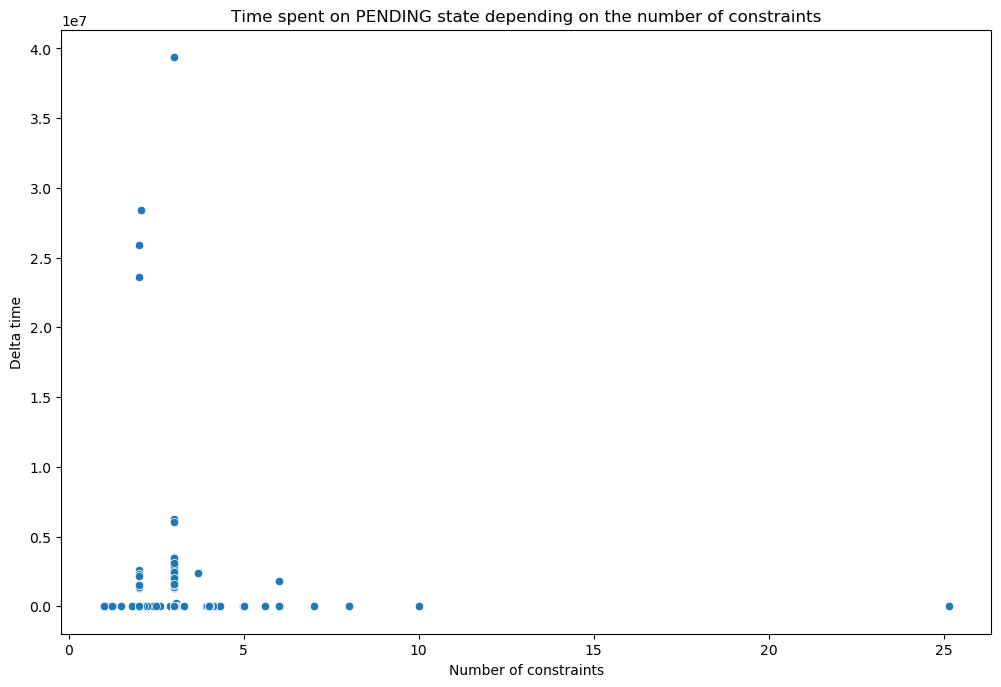

In [48]:
# Create the list of values from the last RDD
rdd_to_map = rdd_delta_constraints.collectAsMap()
deltatimes = [v[0] for v in rdd_to_map.values()]
constraints = [v[1] for v in rdd_to_map.values()]

# And then pass it to seaborn to create a barplot to have a global view
g = sns.scatterplot(x=constraints, y=deltatimes)

g.set_xlabel("Number of constraints")
g.set_ylabel("Delta time")

g.set_title("Time spent on PENDING state depending on the number of constraints")

### Cluster execution

**Data:**
* RDD and DF:

![Job 8 - Both datastructs](results/job_8_df/job8.df_result.png)

**Time:**
* RDD cluster: 403.37 s
* DF cluster: 120.15 s

## Conclusion

Several obesvations can be drawn from our experimentations.

First of all, as we were suggesting at the beginning of the project, doing the analysis on an "average PC" does not allows us to process the entirety of the dataset in a reasonable time. Treating more than 2-3 parts of the provided tables quickly leaded to a bottleneck in terms of computing power, as the analysis took more than 10 minutes on heavy operations.

On the other side, running the tasks on a Google Cloud instance gives several advantages that reduces the processing time by far, and allows us to treat more data at once :

- GCP allows to copy seamlessly the tables from the public bucket to ours, thus removing the downloading delay (not really part of the processing time in itself, but still important to consider).

- In addition, running in the cloud allows to use more workers on different machines. This means that more computing power is allocated to dataset manipulations that often heavily consumes resources.

All of this allows to process the analysis on the entirety of the tables (apart from one or two jobs that were definitely too heavy to be processed on gigabytes of data at once, and for which we still had to select a randomized 10%-subset over the entire table), and to print real statistics valid on the full dataset, instead of doing assumptions from a small selection that does not represents the reality of the situation.

In terms of efficiency, we achieved shorter computation times on jobs running on a cloud instance and relying in a DataFrame than on jobs relying on Resilient Distributed Datasets.

This is probably due to the fact that we are working on sets of structured data. These are more fitted for DataFrames, that are specifically designed for structured data (organization in named columns, like in a relationnal database), while RDDs are a better fit for unstructured data.

Finally, this project allowed us to: 

- Put in application several of the Spark concepts over a small subset on a local environment
- Extend the application over a real use-case, by executing it "in the cloud" with access to more "computation resources"
- Understand the importance and the use cases of the data structures used by Spark
